# MLE Hyperparameter Tuning

In this phase we tune the hyperparameter in order to:
- choose the best optimizer for each model
- choose the correct minibatch size, if required
- set the learning rate
- set the ratio between $\epsilon$ learning rate and $X_0$ learning rate, for NBCM
- select the number of epochs

Initially FBCM, PBCM and NBCM were called simple_BC, BC_observed_positive, BC_with_evidence, so the nomenclature could vary.

In [1]:
from importlib import reload
import sys
sys.path += ["../src"]
import opinion_dynamics_models_estimation as oe
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import pandas as pd
from tqdm import tqdm
import numpy as np
import repeat_function
from torcheval.metrics.functional import r2_score

In [ ]:
hide_progress = True
repetitions = 12

nested_simulations = []


for _ in tqdm(range(repetitions)):
    epsilon, mu = np.random.random(2) / 2
    rho = 16
    
    # the function nested_rep is used to repeat the experiments
    # it takes as input [fn, fixed_params, varying params, repetitions], and [fn, fixed_params, varying params, repetitions]
    # the first list has (i) function to be repeated (for creating X, edges, evidences), (ii) the parameters that are fixed for every experiments, with corresponding values,
    # (iii) the parameters that vary for every experiments, with corresponding list of values (empty in this case), 
    # (iiii) the number of repetition for each combination of varying parameters
    # For each experiment, we create a trace X, edges, and perform several estimations, with the repetitions encoded in the second list
    # in this case, for repetitions times (12), we create one trace with input N, T..., and repeat the estimation for
    # each combination of optimizer, num_epochs, lr, model_name and minibatch_size
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "T": 64, "edge_per_t": 16, "evidences_per_t": 8, "parameters": [epsilon, mu, rho]}, 
                                                      {},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {"epsilon0": 0.25,
                                                       "hide_progress": hide_progress,
                                                       "min_epochs":min_epochs, "parameters": [epsilon, mu, rho], 
                                                       "summarized": True},
                                                      {"optimizer_name": ["adam", "RMSprop", "adagrad", "nadam", "SGD"], 
                                                       "num_epochs": [200, 400, 800],
                                                       "lr": [0.0001, 0.0005, 0.001, 0.005, 0.01,0.05, 0.1], 
                                                       "model_name": ["simple_BC", "BC_with_evidence", "BC_observed_positive"],
                                                       "minibatch_size": [0, 16, 32]
                                                      }, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = True
                               )


In [52]:
# we transorm the list of experimental results in a pandas dataframe
simulations_df = pd.DataFrame(nested_simulations)\
.assign(real_epsilon = lambda x: [u[0] for u in x["parameters"]],
        mu = lambda x: [u[1] for u in x["parameters"]],
        rho = lambda x: [u[2] for u in x["parameters"]]
       )\
.drop("parameters", axis = 1)\
.assign(distance_epsilon = lambda x: np.abs(x["real_epsilon"] -  x["epsilon_estimated"]))\
.assign(early_stopping = lambda x: x["num_epochs"])\
.assign(max_epochs = list(np.repeat(np.array([201, 401, 801]), 7*3*3)) * 60)

In [27]:
simulations_df.to_csv("../data/nested_simulations_230719.csv", index = None)

In [18]:
simulations_df = pd.read_csv("../data/nested_simulations_230719.csv")

## simple_BC (FBCM)

In [19]:
simple_BC_simulations = simulations_df.query("model_name == 'simple_BC'")

#### Minibatching is not useful

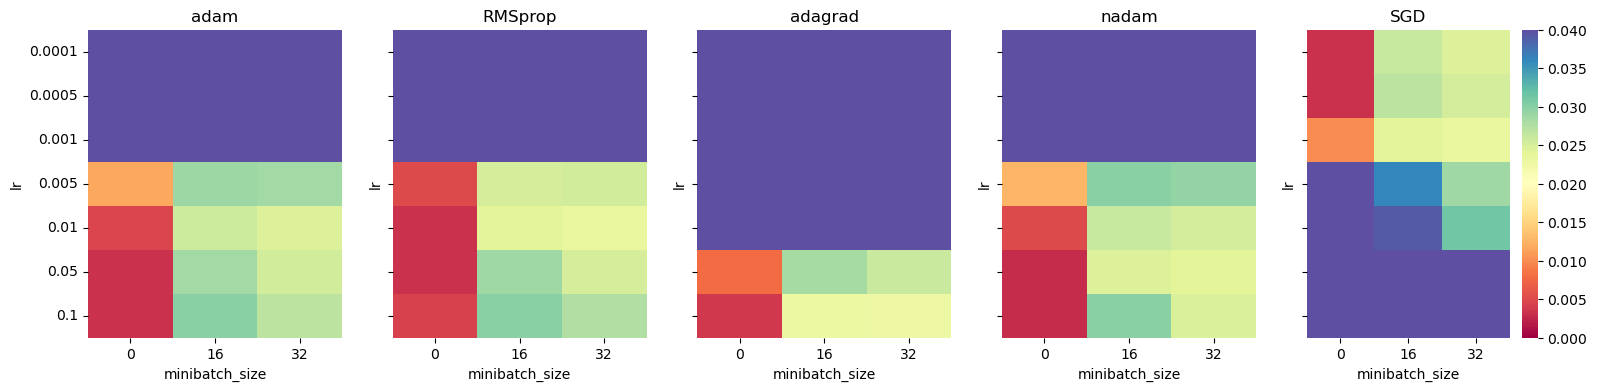

In [20]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (19, 4), sharey = True)

for ax, opt in zip(axes.ravel(), ["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    sns.heatmap(simple_BC_simulations.query("(optimizer_name == @opt)").groupby(["lr", "minibatch_size"]).mean()["distance_epsilon"].unstack(),
                cmap = "Spectral", vmin = 0.0, vmax = 0.04, ax = ax, cbar = opt == "SGD")
    ax.set_title(opt)

#### 200 epochs should be enough

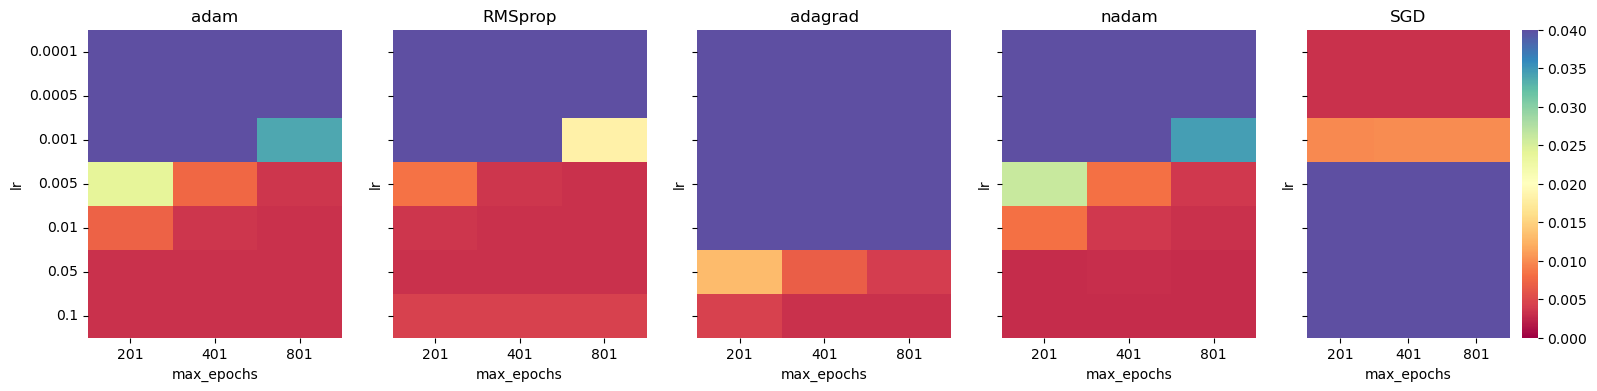

In [21]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (19, 4), sharey = True)

for ax, opt in zip(axes.ravel(), ["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    sns.heatmap(simple_BC_simulations.query("(minibatch_size == 0)&(optimizer_name == @opt)").groupby(["lr", "max_epochs"]).mean()["distance_epsilon"].unstack(),
                cmap = "Spectral", vmin = 0.0, vmax = 0.04, ax = ax, cbar = opt == "SGD")
    ax.set_title(opt)

#### nadam lr = 0.1 is the best optimizer

In [22]:
simple_BC_simulations.query("minibatch_size == 0").groupby(["lr", "max_epochs", "optimizer_name"]).mean().sort_values("distance_epsilon")[["distance_epsilon", "early_stopping"]].reset_index().head(20)

,lr,max_epochs,optimizer_name,distance_epsilon,early_stopping
0,0.1000,201,nadam,0.002867,96.166667
1,0.1000,801,nadam,0.002877,146.166667
2,0.1000,401,nadam,0.002925,112.833333
3,0.0500,201,nadam,0.002932,116.500000
4,0.0500,801,nadam,0.002962,166.500000
5,0.0500,401,nadam,0.002969,133.166667
6,0.0005,201,SGD,0.003169,196.750000
7,0.1000,201,adam,0.003173,196.500000
8,0.1000,401,adam,0.003174,201.666667
9,0.1000,801,adam,0.003174,201.666667


In [24]:
best_simple_BC = simple_BC_simulations.query("(optimizer_name == 'nadam')&(max_epochs == 201)&(lr == 0.1)&(minibatch_size == 0)")

<AxesSubplot:xlabel='real_epsilon', ylabel='epsilon_estimated'>

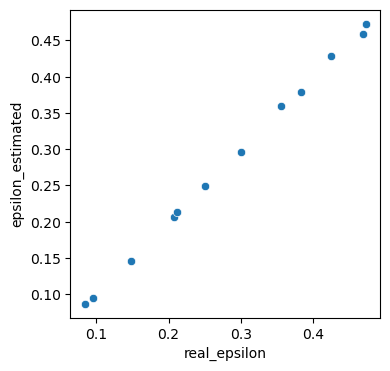

In [27]:
fig, axes = plt.subplots(figsize = (4,4))
sns.scatterplot(data = best_simple_BC, x = "real_epsilon", y = "epsilon_estimated")

## observed_positive_BC (PBCM)

In [29]:
obs_pos_BC_simulations = simulations_df.query("model_name == 'BC_observed_positive'")

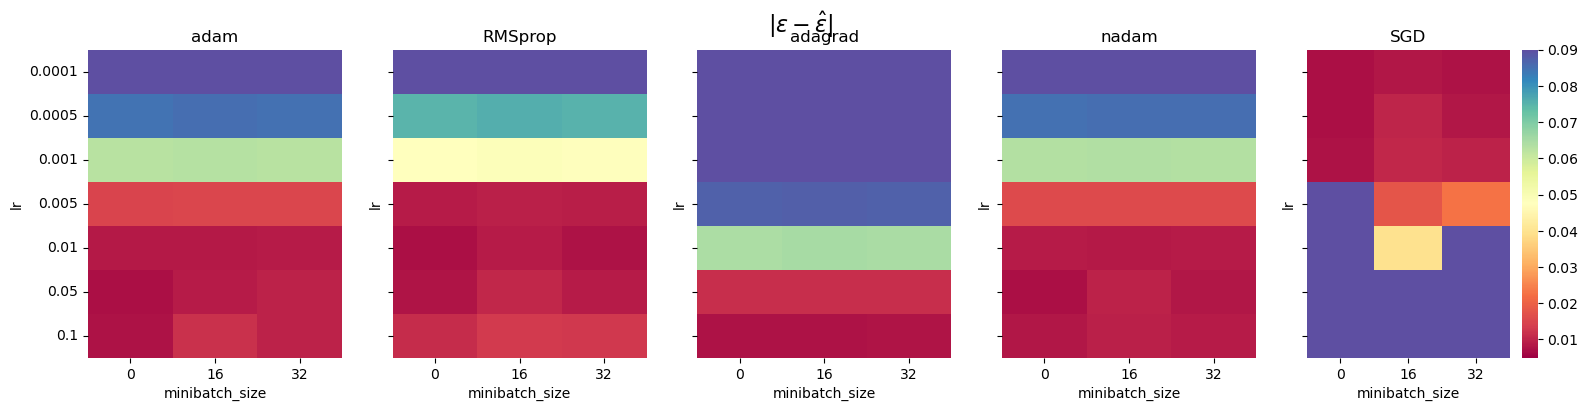

In [37]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (19, 4), sharey = True)
fig.suptitle("$|\epsilon - \hat{\epsilon}|$", fontsize = 16)
for ax, opt in zip(axes.ravel(), ["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    sns.heatmap(obs_pos_BC_simulations.query("(optimizer_name == @opt)").groupby(["lr", "minibatch_size"]).mean()["distance_epsilon"].unstack(),
                cmap = "Spectral", vmin = 0.005, vmax = 0.09, ax = ax, cbar = opt == "SGD")
    ax.set_title(opt)

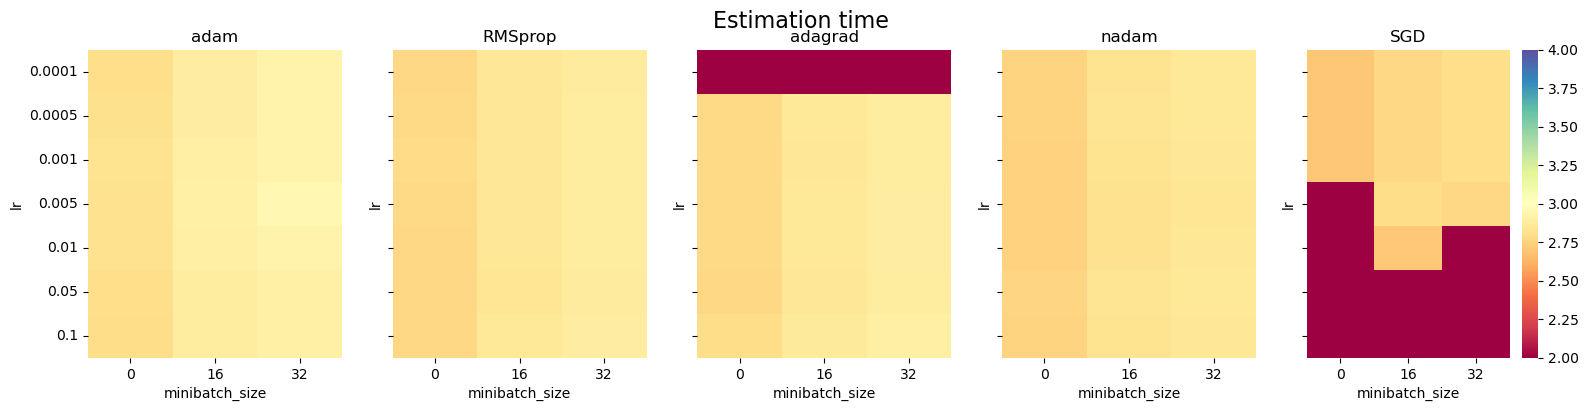

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (19, 4), sharey = True)

fig.suptitle("Estimation time", fontsize = 16)
for ax, opt in zip(axes.ravel(), ["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    sns.heatmap(obs_pos_BC_simulations.query("(optimizer_name == @opt)").groupby(["lr", "minibatch_size"]).mean()["time"].unstack(),
                cmap = "Spectral", vmin = 2, vmax = 4, ax = ax, cbar = opt == "SGD")
    ax.set_title(opt)

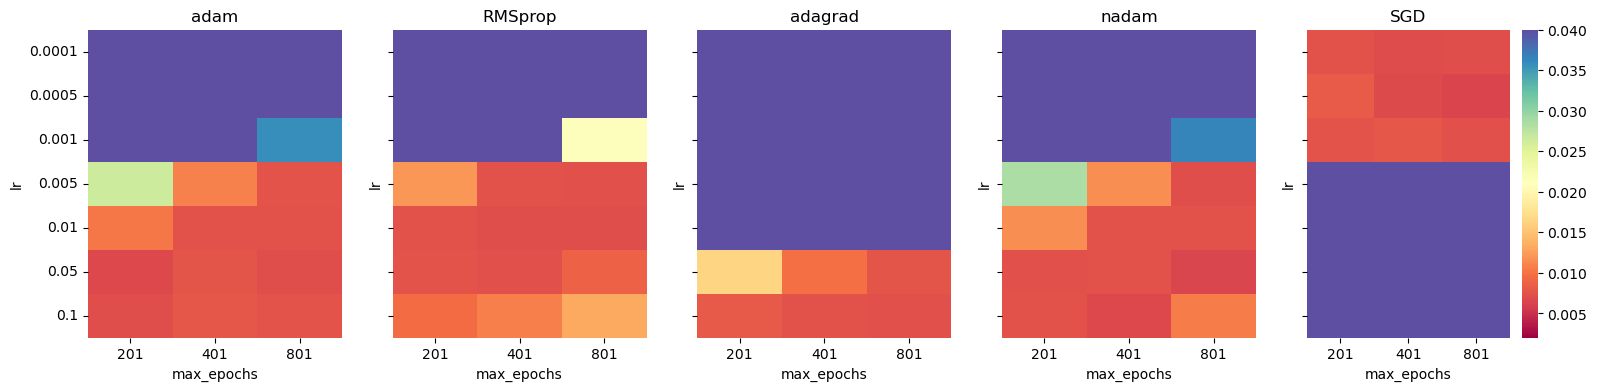

In [39]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (19, 4), sharey = True)

for ax, opt in zip(axes.ravel(), ["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    sns.heatmap(obs_pos_BC_simulations.query("(minibatch_size == 0)&(optimizer_name == @opt)").groupby(["lr", "max_epochs"]).mean()["distance_epsilon"].unstack(),
                cmap = "Spectral", vmin = 0.002, vmax = 0.04, ax = ax, cbar = opt == "SGD")
    ax.set_title(opt)

#### Adam 200 epochs, lr = 0.05

In [40]:
obs_pos_BC_simulations.query("minibatch_size == 0").groupby(["lr", "max_epochs", "optimizer_name"]).mean().sort_values("distance_epsilon")[["distance_epsilon", "early_stopping"]].reset_index().head(10)

,lr,max_epochs,optimizer_name,distance_epsilon,early_stopping
0,0.0005,801,SGD,0.006417,801.0
1,0.0500,801,nadam,0.006588,801.0
2,0.1000,401,nadam,0.006676,401.0
3,0.0500,201,adam,0.006734,201.0
4,0.0005,401,SGD,0.006808,401.0
5,0.0001,401,SGD,0.006981,401.0
6,0.1000,201,adam,0.007054,201.0
7,0.0100,801,RMSprop,0.007055,801.0
8,0.0050,801,nadam,0.007098,801.0
9,0.0001,801,SGD,0.007126,801.0


In [41]:
best_obs_pos_BC = obs_pos_BC_simulations.query("(optimizer_name == 'adam')&(max_epochs == 201)&(lr == 0.05)&(minibatch_size == 0)")


<AxesSubplot:xlabel='real_epsilon', ylabel='epsilon_estimated'>

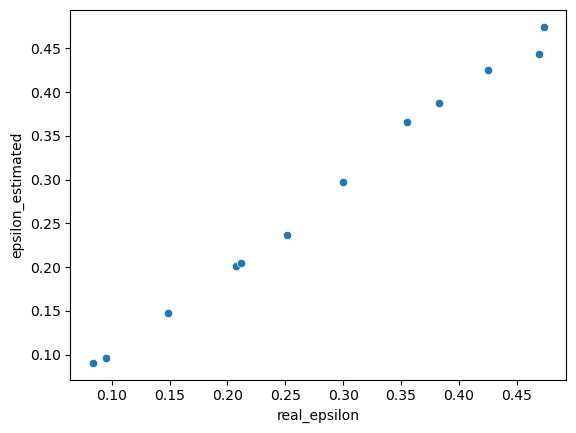

In [68]:
sns.scatterplot(data = best_obs_pos_BC, x = "real_epsilon", y = "epsilon_estimated")

## BC_with_evidences

In [ ]:
hide_progress = True
repetitions = 12

nested_simulations = []


for _ in tqdm(range(repetitions)):
    epsilon, mu = np.random.random(2) / 2
    rho = 16
    
    
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "T": 64, "edge_per_t": 16, "evidences_per_t": 8, "parameters": [epsilon, mu, rho]}, 
                                                      {},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {"epsilon0": 0.25,
                                                       "hide_progress": hide_progress, 
                                                       "parameters": [epsilon, mu, rho], 
                                                       "summarized": True},
                                                      {"optimizer_name": ["adam", "RMSprop", "nadam"], 
                                                       "num_epochs": [200, 400, 800],
                                                       "lr": [0.001, 0.005, 0.01,0.05, 0.1], 
                                                       "model_name": ["BC_with_evidence"],
                                                       "minibatch_size": [0, 16, 32],
                                                       "X0_lr_scale": [1, 10]
                                                       
                                                      }, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = True
                               )
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "T": 64, "edge_per_t": 16, "evidences_per_t": 8, "parameters": [epsilon, mu, rho]}, 
                                                      {},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {"epsilon0": 0.25,
                                                       "hide_progress": hide_progress, "patience": patience, "min_delta":min_delta,
                                                       "min_epochs":min_epochs, "sample_pairs": 50,"parameters": [epsilon, mu, rho], 
                                                       "summarized": True},
                                                      {"optimizer_name": ["SGD"], 
                                                       "num_epochs": [200, 400, 800],
                                                       "lr": [0.0001, 0.0005, 0.001, 0.005, 0.01], 
                                                       "model_name": ["BC_with_evidence"],
                                                       "minibatch_size": [0, 16, 32],
                                                       "X0_lr_scale": [1, 10]
                                                       
                                                      }, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = True
                               )



  0%|                                                      | 0/12 [00:00<?, ?it/s]

In [ ]:
simulations_df = pd.DataFrame(nested_simulations)\
.assign(real_epsilon = lambda x: [u[0] for u in x["parameters"]],
        mu = lambda x: [u[1] for u in x["parameters"]],
        rho = lambda x: [u[2] for u in x["parameters"]]
       )\
.drop("parameters", axis = 1)\
.assign(distance_epsilon = lambda x: np.abs(x["real_epsilon"] -  x["epsilon_estimated"]))

In [ ]:
simulations_df.to_csv("../data/hyperparams_evidences_230901.csv", index = None)

In [61]:
simulations_df = pd.read_csv("../data/hyperparams_evidences_230729.csv")

In [64]:
evidences_BC_simulations = simulations_df.query("model_name == 'BC_with_evidence'")